In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, Javascript, Markdown as md

# Import & Clean Dataset

In [2]:
df = pd.read_csv('insurance_data.csv',delimiter=';',decimal=',')

In [3]:
df.head()

,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal
0,1,F,0.0,Yes,Yes,23,Yes,No,No,NaN,12.0,Yes,19.65,"451,55",Y
1,2,F,1.0,No,No,42,Yes,Yes,Class A,3,1.0,Yes,84.65,"3541,35",N
2,3,F,0.0,Yes,No,72,Yes,No,No,NaN,12.0,No,19.40,"1496,45",Y
3,4,F,0.0,Yes,Yes,13,Yes,No,No,NaN,12.0,No,19.55,"265,3",Y
4,5,F,0.0,No,No,37,Yes,Yes,Class A,"3,4",1.0,No,100.30,"3541,4",Y


In [4]:
#check null values
df.isnull().sum()

insuree#                       0
gender                       113
is45OrOlder                   96
isMarried                      0
hasKids                        0
insuredMonths                  0
termLifeInsurance              0
multipleTermLifePolicies       0
healthInsurance                0
healthRiders                1982
premiumFrequency             114
eStatements                    0
monthlyPremium                 0
totalPremium                   0
renewal                        0
dtype: int64

In [5]:
# Check unique values for each column
for c in df.columns:
    print(f"Unique values for column {c}")
    print(df[c].unique(),'\n')

Unique values for column insuree#
[   1    2    3 ... 5498 5499 5500] 

Unique values for column gender
['F' 'M' nan] 

Unique values for column is45OrOlder
['0.0' '1.0' nan] 

Unique values for column isMarried
['Yes' 'No'] 

Unique values for column hasKids
['Yes' 'No'] 

Unique values for column insuredMonths
[ 23  42  72  13  37   3  24  31   1  57   6   7  65  40  18  15   2   4
  69   0  59  16  66  27  29  11  61  39  41  62  70  56  30  22  71  54
  20  26  55  51   5  58  32 170  12  67  14  43  33  60  25   9  45  21
  19  36  44  34   8  53  52  46  17  50  63  10  35  68  38  49  64  48
 130 410  47  28 670 720 610 180 550 160 430 340 710 520 230 690 220 420
 460 700 240 620  80 600 320 260 470] 

Unique values for column termLifeInsurance
['Yes' 'No'] 

Unique values for column multipleTermLifePolicies
['No' 'Yes' 'no term life policy taken' 'term life policy not taken'] 

Unique values for column healthInsurance
['No' 'Class A' 'Class B'] 

Unique values for column health

## Data cleaning

In [6]:
# make copy of dataframe
clean_df = df.copy()

In [7]:
# Remap free text values to No
free_text_life_policies = {'no term life policy taken','term life policy not taken'}
clean_df['multipleTermLifePolicies'] = clean_df['multipleTermLifePolicies'].apply(lambda x: 'No' if x in free_text_life_policies else x)

clean_df['multipleTermLifePolicies'].unique()

array(['No', 'Yes'], dtype=object)

In [8]:
#Convert comma to decimal for dollar figure columns
def clean_totalPremium(x):
    if x == np.nan or len(x.strip()) == 0:
        return np.nan
    else:
        return float(x.replace(',', '.'))

clean_df['totalPremium'] = clean_df['totalPremium'].apply(clean_totalPremium)

In [7]:
#map boolean columns
free_text_yesno_map = {'Yes':True,'No':False,np.nan:np.nan}
bool_map = {
    'is45OrOlder':{'1.0':True,'0.0':False,np.nan:np.nan},
    'isMarried':free_text_yesno_map,
    'hasKids':free_text_yesno_map,
    'termLifeInsurance':free_text_yesno_map,
    'multipleTermLifePolicies':free_text_yesno_map,
    'eStatements':free_text_yesno_map,
    'renewal':{'Y':True,'N':False,np.nan:np.nan}
}

for col,d in bool_map.items():
    clean_df[col] = clean_df[col].map(d).astype(bool)

In [9]:
#convert categorical columns
clean_df['gender'] = clean_df['gender'].astype('category')
clean_df['healthInsurance'] = clean_df['healthInsurance'].astype('category')

In [10]:
#convert healthrider column to tuple 
import ast
def convert_to_tuple(x):
    if pd.isnull(x):
        return ()
    else:
        x = ast.literal_eval(x)
    if isinstance(x,tuple):
        return x
    else:
        return (x,)
clean_df['healthRiders'] = clean_df['healthRiders'].apply(convert_to_tuple)

In [ ]:
#create boolean columns for each of the 4 riders

max_healthRiders = 4 #inferred from unique values

new_healthRiders_columns = [f"healthRider_{i}" for i in range(1,max_healthRiders+1)]

def expand_healthRiders_list(x):
    riders = x['healthRiders']
    result = []
    
    for i in range(1,max_healthRiders+1):
        result.append(i in riders)
    return result

clean_df[new_healthRiders_columns] = clean_df.apply(expand_healthRiders_list, result_type='expand',axis=1)

In [12]:
print(clean_df.info())
clean_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   insuree#                  5500 non-null   int64   
 1   gender                    5387 non-null   category
 2   is45OrOlder               5404 non-null   object  
 3   isMarried                 5500 non-null   object  
 4   hasKids                   5500 non-null   object  
 5   insuredMonths             5500 non-null   int64   
 6   termLifeInsurance         5500 non-null   object  
 7   multipleTermLifePolicies  5500 non-null   object  
 8   healthInsurance           5500 non-null   category
 9   healthRiders              5500 non-null   object  
 10  premiumFrequency          5386 non-null   float64 
 11  eStatements               5500 non-null   object  
 12  monthlyPremium            5500 non-null   float64 
 13  totalPremium              5491 non-null   float6

,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal
0,1,F,0.0,Yes,Yes,23,Yes,No,No,(),12.0,Yes,19.65,451.55,Y
1,2,F,1.0,No,No,42,Yes,Yes,Class A,"(3,)",1.0,Yes,84.65,3541.35,N
2,3,F,0.0,Yes,No,72,Yes,No,No,(),12.0,No,19.40,1496.45,Y
3,4,F,0.0,Yes,Yes,13,Yes,No,No,(),12.0,No,19.55,265.30,Y
4,5,F,0.0,No,No,37,Yes,Yes,Class A,"(3, 4)",1.0,No,100.30,3541.40,Y


# EDA

### (Utility functions)

In [13]:
def create_subplots(n,figsize=(15, 25)):
    if n%2 == 0:
        fig, axes = plt.subplots(n//2, 2, figsize=figsize)
    else:
        fig, axes = plt.subplots(n//2+1, 2, figsize=figsize)
        i,j = (n-1)//2, 1
        fig.delaxes(axes[i,j])

    axes_idx = [[i,j] for i in range(4) for j in range(2)]
    
    return fig, axes, axes_idx

### Univariate analysis

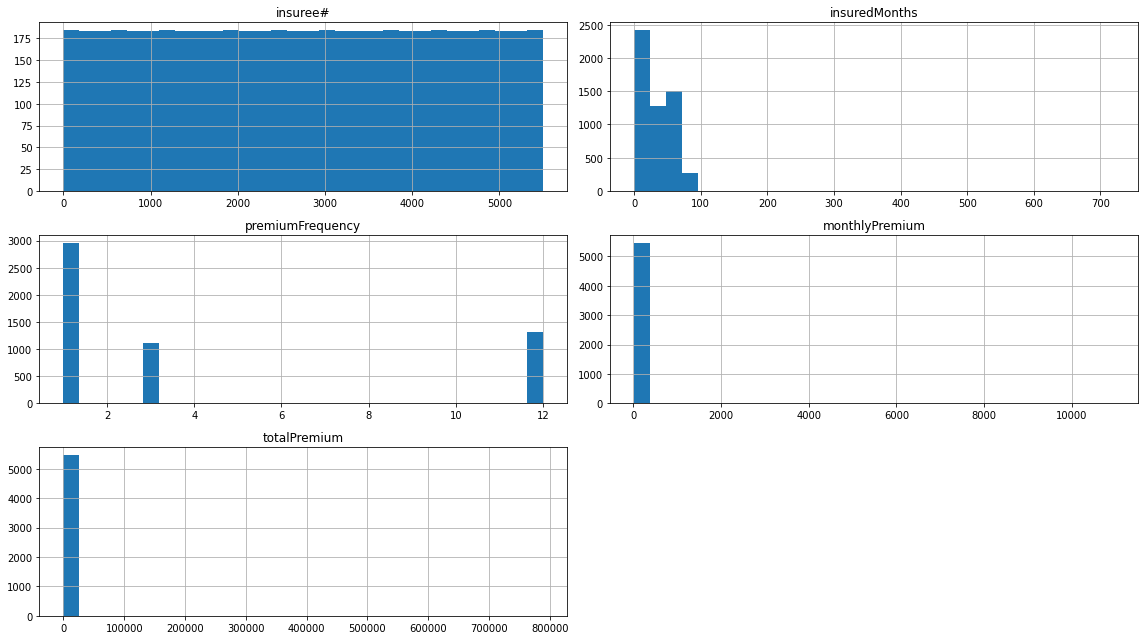

In [14]:
clean_df.hist(figsize=(16,9),bins=30)
plt.tight_layout()

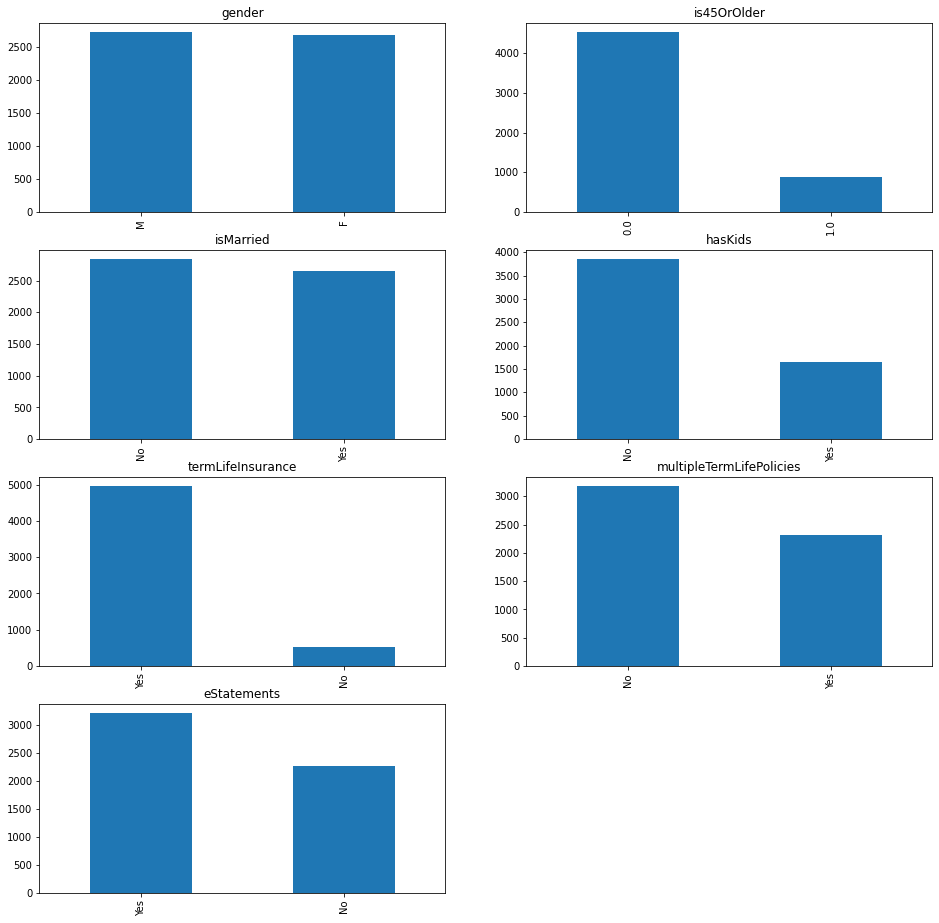

In [15]:
bool_cols = ['gender','is45OrOlder','isMarried','hasKids','termLifeInsurance','multipleTermLifePolicies','eStatements']
n = len(bool_cols)
fig,axes,axes_idx = create_subplots(n,figsize=(16,16))
display(md("""### Categorical & Binary Variable Distributions

"""))
for col,ax in list(zip(bool_cols,axes_idx[:n])):
    clean_df[col].value_counts().plot(kind='bar',ax=axes[ax[0],ax[1]],title=col)
